In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
import re
from datetime import datetime as dt
import time
import csv
import requests
import urllib.parse

import json

In [50]:
rawGames = pd.read_csv('SteamAppsInfo.csv', encoding = "ISO-8859-1")

In [4]:
rawGames

,appId,name,developerName,releaseDate,price,numReviews,positiveReviewPercentage,appGenre,tagsList,appType,dlcBool,appDesc,alteredTextBool
0,1688200,War Of Gold,"Tero Lunkka,Valkeala Software","Aug 22, 2021",0.59,15.0,66%,"['Action', 'Casual', 'Indie']","['Casual', 'Action', '3D Fighter', 'Shooter', ...",All Games,False,You super hero soldier need save robber gold b...,False
1,1688210,Utopia,Iconic Ideaz,"Jan 7, 2022",NaN,NaN,NaN,"['Action', 'Adventure', 'Massively Multiplayer...","['Early Access', 'RPG', 'Survival', 'Colorful'...",All Games,False,UTOPIA is an open world survival game set in a...,False
2,1688220,Fire & Reign,Siphon Shock,Jun 2022,NaN,NaN,NaN,"['Action', 'Indie']","['Bullet Hell', 'Action', ""Shoot 'Em Up"", 'Sho...",All Games,False,Upgrade your warriors and shoot through waves ...,False
3,1688240,Escape from the Office,"ParachuteGames, ImperiumGame","Jul 26, 2021",2.99,12.0,91%,"['Action', 'Indie']","['Action', 'Precision Platformer', 'Perma Deat...",All Games,False,Escape from the Office is a 2D side-scrolling ...,False
4,1688250,PRINCESS IN AIRINESS,Broken Desk,"Jul 26, 2021",3.99,2.0,NaN,"['Action', 'Indie']","['Action', 'Point & Click', '2D Platformer', '...",All Games,False,"To pray for peace, the princess once again fli...",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113005,1972180,Dub Club,Cyberfunk Studios LLC,"May 20, 2022",0.00,NaN,NaN,"['Casual', 'Free to Play']","['Casual', 'Rhythm', 'Exploration', 'Third Per...",All Games,False,A third person multiplayer virtual music venue...,False
113006,1595760,ScreenSpace,Wave Project,"Apr 23, 2021",1.99,1.0,NaN,"['Casual', 'Indie']","['Casual', 'Clicker', 'Arcade', 'Point & Click...",All Games,False,Test your focus and reflexes in this simplisti...,False
113007,1996680,Fowl Scourge,Void Cup Games,When its done,NaN,NaN,NaN,"['Action', 'Indie', 'RPG']",[],All Games,False,In this Dark Fantasy Action-RPG you are part o...,False
113008,1972250,Project: Maidenless,Grossly Incandescent Games,TBA,NaN,NaN,NaN,"['Action', 'Adventure', 'Indie', 'Massively Mu...","['Early Access', 'Action', 'Adventure', 'RPG',...",All Games,False,Scavenge for loot in an unforgiving world fill...,False


In [5]:
len(rawGames['appId'].to_list())

113010

In [6]:
#Now to try and get the dates.
#
#Note that this script eliminates dates which don't fit certain date formats.
#
#For example, it converts "Coming Soon" to NaN.
def datesCleaned(dataframe):
    
    datesCleaned = [];
    
    #Convert to dt format
    for i in dataframe['releaseDate']:
        try:
            datesCleaned.append(dt.strptime(i, '%b %d, %Y'))
        except:
            try:
                datesCleaned.append(dt.strptime(i, '%b, %Y'))
                
            except:
                try: datesCleaned.append(dt.strptime(i, '%b %Y'))
                    
                except:
                    datesCleaned.append(np.nan)
            
    datesCleanedSeries = pd.Series(datesCleaned)
    
    datesCleanedSeries.index = dataframe.index
    
    return datesCleanedSeries

datesCleaned = datesCleaned(rawGames)

#Replece release dates with cleaned dates
rawGames['releaseDate'] = datesCleaned
        
# #Add cleaned release dates to dataframes
# ncrpgs_df['releaseDate'] = rpgDatesCleaned[ncrpgs_df.index]
# crpgs_df['releaseDate'] = rpgDatesCleaned[crpgs_df.index]

In [7]:
#Clean all the game tags
def tagsCleaned(games):
    
    tagsCleaned = []
    
    for k in games.index:
        
        #Get rid of \' \s \em etc.
        tagsRemovedSlashes = re.findall(r"'(.*?)'[,\]]",games.tagsList[k]\
                                        .replace("\'s","s").replace("\'em","em")\
                                        .replace("\'Em","Em").replace("\'","''"))
        
        tagsCleaned.append([tagsRemovedSlashes[j].replace("'","") for j in range(len(tagsRemovedSlashes))])
        
    tagsCleanedSeries = pd.Series(tagsCleaned)
    
    tagsCleanedSeries.index = games.index
        
    return tagsCleanedSeries

rawGames['tagsList'] = tagsCleaned(rawGames)

print(rawGames['tagsList'][0])

['Casual', 'Action', '3D Fighter', 'Shooter', 'Runner', 'Real Time Tactics', 'Hero Shooter', '3D', 'Military', 'Stealth', 'Flight', 'Survival', 'Story Rich', 'Combat', 'Singleplayer', 'Third-Person Shooter', 'Vehicular Combat', 'Indie', 'First-Person', 'Character Customization']


In [8]:
#Find all non-DLC RPGs and CRPGs
rpgs = rawGames[[('RPG' in rawGames.tagsList[i]) or ('CRPG' in rawGames.tagsList[i])
                 for i in range(len(rawGames))]][rawGames['dlcBool'] == False]

C:\Users\phyis\AppData\Local\Temp/ipykernel_29808/183280176.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rpgs = rawGames[[('RPG' in rawGames.tagsList[i]) or ('CRPG' in rawGames.tagsList[i])


In [9]:
def tagBool(games,tagNames):
    
    #Check for a tag name in every game in dataframe
    tagBoolSeries = pd.Series([any([tagName in games['tagsList'][j] for tagName in tagNames]) for j in games.index])
    
    tagBoolSeries.index = games.index
    return tagBoolSeries

#Get list of Booleans corresponding to whether the game is a CRPG
crpgBool = tagBool(rpgs, ['CRPG'])

In [10]:
#All CRPGs
crpgs_df = rpgs.copy()[crpgBool.tolist()]

#All non-CRPG RPGs (nCRPGs)
ncrpgs_df = rpgs.copy()[np.logical_not(crpgBool.tolist())]

In [11]:
any([True,False])

True

In [12]:
ncrpgs_df.head()

,appId,name,developerName,releaseDate,price,numReviews,positiveReviewPercentage,appGenre,tagsList,appType,dlcBool,appDesc,alteredTextBool
1,1688210,Utopia,Iconic Ideaz,2022-01-07,NaN,NaN,NaN,"['Action', 'Adventure', 'Massively Multiplayer...","[Early Access, RPG, Survival, Colorful, Base B...",All Games,False,UTOPIA is an open world survival game set in a...,False
8,1688320,OneBit Adventure,"Galactic Slice, LLC",2022-08-05,0.00,NaN,NaN,"['Adventure', 'Casual', 'Free to Play', 'Indie...","[Roguelite, Roguelike, Class-Based, Dungeon Cr...",All Games,False,OneBit Adventure is a casual turn-based roguel...,False
26,1688600,Emperial Knights,Yacine Kalache,2022-04-20,9.99,NaN,NaN,"['Action', 'RPG', 'Early Access']","[Action, RPG, Action RPG, Hack and Slash, 3D, ...",All Games,False,You incarnate as a powerful knight to help the...,False
27,1688630,Emperial Knights,Yacine Kalache,2022-04-20,9.99,NaN,NaN,"['Action', 'RPG', 'Early Access']","[Action, RPG, Action RPG, Hack and Slash, 3D, ...",All Games,False,You incarnate as a powerful knight to help the...,False
28,1688640,Cleanup on Isle Goblin,Kilowatt Games,NaT,NaN,NaN,NaN,"['Adventure', 'Indie', 'RPG', 'Simulation']","[Life Sim, RPG, Pixel Graphics, Adventure, Cra...",All Games,False,Isle Goblin has been invaded by destructive hu...,False


In [13]:
crpgs_df.head()

,appId,name,developerName,releaseDate,price,numReviews,positiveReviewPercentage,appGenre,tagsList,appType,dlcBool,appDesc,alteredTextBool
218,1686130,Deep Despair 2,BekkerDev Studio,2021-10-08,6.99,67.0,88%,"['Adventure', 'Indie', 'RPG', 'Simulation']","[Sandbox, Crafting, Adventure, Survival, Simul...",All Games,False,Deep Despair 2 is an open world survival adven...,False
458,1684240,Metal Faith,Youth Game,2021-08-02,9.99,NaN,NaN,"['Adventure', 'Indie', 'RPG']","[Adventure, RPG, Action-Adventure, Shooter, Pu...",All Games,False,A 3D adventure puzzle game,False
459,1684250,The Evil Farming Game: Replanted,Jeremy Does Stupid Stuff,NaT,0.00,NaN,NaN,"['Adventure', 'Free to Play', 'Indie', 'RPG']","[RPG, Psychological Horror, Horror, Multiple E...",All Games,False,"What will you do when you, an ordinary farmer,...",False
464,1684310,The Evil Farming Game: Replanted,Jeremy Does Stupid Stuff,NaT,0.00,NaN,NaN,"['Adventure', 'Free to Play', 'Indie', 'RPG']","[RPG, Psychological Horror, Horror, Multiple E...",All Games,False,"What will you do when you, an ordinary farmer,...",False
479,1683870,Crystalreach Islands,Majao Games,NaT,NaN,NaN,NaN,['RPG'],"[RPG, Fantasy, Action RPG, Open World, Sandbox...",All Games,False,Crystalreach Islands is an open-world action R...,False


In [14]:
rpgs.tagsList.replace("\'s","s").replace("\'em","em").replace("\'Em","Em").replace("\'","''")

1         [Early Access, RPG, Survival, Colorful, Base B...
8         [Roguelite, Roguelike, Class-Based, Dungeon Cr...
26        [Action, RPG, Action RPG, Hack and Slash, 3D, ...
27        [Action, RPG, Action RPG, Hack and Slash, 3D, ...
28        [Life Sim, RPG, Pixel Graphics, Adventure, Cra...
                                ...                        
112994    [Casual, Adventure, RPG, JRPG, Turn-Based Tact...
112995    [RPG, Action RPG, 2D Platformer, Pixel Graphic...
113003    [Strategy, Grand Strategy, Turn-Based Strategy...
113004    [Action, RPG, 2D Fighter, 3D Fighter, JRPG, 3D...
113008    [Early Access, Action, Adventure, RPG, Action ...
Name: tagsList, Length: 15689, dtype: object

In [15]:
rpgDates = datesCleaned[rpgs.index]

In [16]:
#Count number of games over the years
def gameGrowth(games,start_date):
    end_date = dt.now().year

    dates = range(start_date,end_date+1)

    gamesCount=[]
    for date in dates:
        #How many games were released before "date"?
        gamesCount.append(len(games[[games['releaseDate'][i].year < date for i in games.index]].index))
        
    return gamesCount

In [17]:
array = [['a','b'], ['a', 'b','c'], ['a']]
result = {x for l in array for x in l}
print(result)

{'b', 'a', 'c'}


In [18]:
#Get game developer location data
gameDevLocations = pd.read_csv('GameDevLocations.csv',skip_blank_lines=True).dropna()

In [19]:
gameDevLocations.head()

,company,city,state/province,country,alteredTextBool
1,0verflow,Tokyo,Tokyo,Japan,False
3,1 Simple Game,Zapopan,Jalisco,Mexico,False
5,100 Stones Interactive,Brisbane,Queensland,Australia,False
7,1047 Games,Zephyr Cove,Nevada,United States,False
9,10tons,Tampere,Tavastia,Finland,False


In [65]:
def intersection(list1, list2):
    list3 = [value for value in list1 if value in list2]
    return list3

intersection(['all','or','nothing'],['all','nothing'])

['all', 'nothing']

In [118]:
#Split location names into lists of strings to compare between datasets

import re

def locationSplitter(string):
    strings = re.split(r',| |-', string)

    unwantedStrings = ['', 'And', 'The', 'Games', 'Studios', 'Studio', 'Game', 'Games',\
                           'and', 'the', 'games', 'studios', 'studio', 'game', 'games']
    
    newStrings = [i for i in strings if i not in unwantedStrings]
    
    return newStrings

In [119]:
#Get lists of split game developer name strings from each dataset

steamGameDevLocationsSplit = [];
gameDevLocationsSplit = []

for string in rawGames.developerName.tolist():
    
    try:
        steamGameDevLocationsSplit.append(locationSplitter(string))
        
    except TypeError:
        steamGameDevLocationsSplit.append(np.nan)
        pass
    
for string in gameDevLocations.company.tolist():
    
    try:
        gameDevLocationsSplit.append(locationSplitter(string))
        
    except TypeError:
        gameDevLocationsSplit.append(np.nan)
        pass

In [154]:
gameDevLocations.reset_index().loc[0]

index                     1
company            0verflow
city                  Tokyo
state/province        Tokyo
country               Japan
alteredTextBool       False
Name: 0, dtype: object

In [186]:
#Create empty lists to fill with info about game developer locations
gameDevNamesList = [];
gameDevCityList = [];
gameDevStateProvinceList = [];
gameDevCountryList = [];

for steamDevNameWords in steamGameDevLocationsSplit:
    
    loop = 0
    
    for gameDevNameWords in gameDevLocationsSplit:
        
        try:
            if len(intersection(steamDevNameWords, gameDevNameWords))/len(steamDevNameWords) >= 0.75:

                locationIndex = gameDevLocationsSplit.index(gameDevNameWords)

                gameDev = gameDevLocations.reset_index().loc[locationIndex]

                gameDevNamesList.append(gameDev[1])
                gameDevCityList.append(gameDev[2])
                gameDevStateProvinceList.append(gameDev[3])
                gameDevCountryList.append(gameDev[4])

                pass
            
        except (ZeroDivisionError, TypeError):
            pass
        
        loop += 1
        
    if loop == len(gameDevLocationsSplit):
        gameDevNamesList.append(np.nan)
        gameDevCityList.append(np.nan)
        gameDevStateProvinceList.append(np.nan)
        gameDevCountryList.append(np.nan)

In [173]:
gameDevStateProvinceList.count(np.nan)/len(gameDevStateProvinceList)

0.854498574701519

In [189]:
gameDevStateProvinceList.count(np.nan)

19569

In [184]:
steamGameDevLocationsSplit

[['Tero', 'Lunkka', 'Valkeala', 'Software'],
 ['Iconic', 'Ideaz'],
 ['Siphon', 'Shock'],
 ['ParachuteGames', 'ImperiumGame'],
 ['Broken', 'Desk'],
 ['NLB', 'project'],
 ['Sprovieri'],
 ['Genesis', 'Arthangel'],
 ['Galactic', 'Slice', 'LLC'],
 ['Vidas', 'Salavejus'],
 ['Appstronaut'],
 ['Guillaume', 'Lamontagne'],
 ['Christian', 'tavares', 'da', 'silva'],
 ['TearStorm', 'Entertainment'],
 ['Team', 'Haruko', 'Please'],
 ['Narog'],
 ['SmartOliveGames', 'Ltd'],
 ['Crooked', 'Road'],
 ['Tlön', 'Industries'],
 ['PITR'],
 ['Cast', 'n', 'Play'],
 ['Exbyte'],
 ['L.S.', 'Frei'],
 ['Graviteam'],
 ['npckc'],
 ['ImageTech', 'LLC'],
 ['Yacine', 'Kalache'],
 ['Yacine', 'Kalache'],
 ['Kilowatt'],
 ['whaleo'],
 ['TigerQiuQiu'],
 ['TigerQiuQiu'],
 ['TigerQiuQiu'],
 ['TigerQiuQiu'],
 ['TigerQiuQiu'],
 ['TigerQiuQiu'],
 ['TigerQiuQiu'],
 ['TigerQiuQiu'],
 ['TigerQiuQiu'],
 ['TigerQiuQiu'],
 ['TigerQiuQiu'],
 ['TigerQiuQiu'],
 ['TigerQiuQiu'],
 ['TigerQiuQiu'],
 ['TigerQiuQiu'],
 ['TigerQiuQiu'],
 ['TigerQ

In [185]:
gameDevLocationsSplit

[['0verflow'],
 ['1', 'Simple'],
 ['100', 'Stones', 'Interactive'],
 ['1047'],
 ['10tons'],
 ['12', 'East'],
 ['12', 'Hit', 'Combo'],
 ['13AM'],
 ['17', 'Bit'],
 ['17', 'Bit'],
 ['1P2P'],
 ['2', 'Awesome'],
 ['2', 'Awesome'],
 ['2', 'Ton'],
 ['2020Venture'],
 ['21', '6', 'Productions'],
 ['22cans'],
 ['2401'],
 ['270soft.com'],
 ['2D', 'Boy'],
 ['2D', 'Nutz'],
 ['2Dogs'],
 ['2k', 'Czech'],
 ['2K', 'Silicon', 'Valley'],
 ['2Pi', 'Interactive'],
 ['2Pt', 'Interactive'],
 ['3', 'Fold'],
 ['3000AD'],
 ['302', 'Interactive'],
 ['31st', 'Union'],
 ['34', 'Big', 'Things'],
 ['343', 'Industries', '(Xbox', 'Studios)'],
 ['3D', 'Avenue'],
 ['3D', 'Realms'],
 ['3d', 'io'],
 ['3DClouds'],
 ['3DIVISION'],
 ['3G'],
 ['3Mind'],
 ['42', 'Entertainment'],
 ['44', 'Bico', 'Largo'],
 ['48H'],
 ['4A', '(Embracer', 'Group)'],
 ['4A', '(Embracer', 'Group)'],
 ['4A', '(Embracer', 'Group)'],
 ['4Bit'],
 ['4J'],
 ['4J'],
 ['4M2Q', 'GAMES'],
 ['4th', 'Wall'],
 ['5', 'Bits'],
 ['5', 'Lives'],
 ['5am'],
 ['5pb.Ga

In [182]:
rawGames.developerName.tolist()

['Tero Lunkka,Valkeala Software',
 'Iconic Ideaz',
 'Siphon Shock',
 'ParachuteGames, ImperiumGame',
 'Broken Desk',
 'NLB project',
 'Sprovieri Games',
 'Genesis Arthangel',
 'Galactic Slice, LLC',
 'Vidas Salavejus',
 'Appstronaut Studios',
 'Guillaume Lamontagne',
 'Christian tavares da silva',
 'TearStorm Entertainment',
 'Team Haruko Please',
 'Narog Games',
 'SmartOliveGames Ltd',
 'Crooked Road',
 'Tlön Industries',
 'PITR',
 'Cast n Play',
 'Exbyte Studios',
 'L.S. Frei',
 'Graviteam',
 'npckc',
 'ImageTech LLC',
 'Yacine Kalache',
 'Yacine Kalache',
 'Kilowatt Games',
 'whaleo',
 'TigerQiuQiu',
 'TigerQiuQiu',
 'TigerQiuQiu',
 'TigerQiuQiu',
 'TigerQiuQiu',
 'TigerQiuQiu',
 'TigerQiuQiu',
 'TigerQiuQiu',
 'TigerQiuQiu',
 'TigerQiuQiu',
 'TigerQiuQiu',
 'TigerQiuQiu',
 'TigerQiuQiu',
 'TigerQiuQiu',
 'TigerQiuQiu',
 'TigerQiuQiu',
 'TigerQiuQiu',
 'TigerQiuQiu',
 'TigerQiuQiu',
 'TigerQiuQiu',
 'TigerQiuQiu',
 'TigerQiuQiu',
 'TigerQiuQiu',
 'GIRLSOUL',
 'The Pixel Hunt',
 'Ove

In [188]:
gameDevNamesList

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 'The Artistocrats',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 'Bird Bath Games',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,

In [20]:
# #Add developer location to rawGames
# gameDevCityList = [];
# gameDevStateProvinceList = [];
# gameDevCountryList = [];
# for i in range(len(rawGames)):
#     if rawGames.loc[i].developerName in gameDevLocations.company.tolist():
        
#         gameDev = gameDevLocations[gameDevLocations.company == rawGames.loc[i].developerName]
        
#         gameDevCityList.append([gameDev.loc[j][1] for j in gameDev.index])
#         gameDevStateProvinceList.append([gameDev.loc[j][2] for j in gameDev.index])
#         gameDevCountryList.append([gameDev.loc[j][3] for j in gameDev.index])
        
#     else:
#         gameDevCityList.append([np.nan])
#         gameDevStateProvinceList.append([np.nan])
#         gameDevCountryList.append([np.nan])

In [21]:
gameDevCountryList.count([np.nan])/len(gameDevCountryList)

0.9243695248208124

In [22]:
len(rawGames.developerName.unique())

43280

In [219]:
address = 'St. Catherines, Ontario, Canada'
url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'

response = requests.get(url).json()
print(response[0]["lat"])
print(response[0]["lon"])


IndexError: list index out of range

In [225]:
len(gameDevCountryList)

132579

In [227]:
100%10

0

In [279]:
#Check if we already have a csv file containing game dev lat/long coordinates
if exists('coordinates.csv'):
    gamesTimeSeries = pd.read_csv('coordinates.csv')
    print('Coordinates data already exists.')

#If not, get the coordinates by querying nominatim.openstreetmap.org with the city/state/country of the game devs
else:    
    latitudes = [];
    longitudes = [];

    startTime = time.time()
    
    for i in range(len(gameDevCountryList)):
        
        #Print progress every 1000 iterations
        if i%1000 == 0:
            print('{} iterations completed in {} seconds.'.format(i,time.time() - startTime))

        address = ''
        
        #Try to add the country, state/province, and city names to the query string
        if str(gameDevCountryList[i]) != 'nan':
            address = gameDevCountryList[i]

        if str(gameDevStateProvinceList[i]) != 'nan':
            address = gameDevStateProvinceList[i] + ', ' + address

        if str(gameDevCityList[i]) != 'nan':
            address += gameDevCityList[i] + ', ' + address
        
        #If we don't have any location information, append NaN to the lists
        if address == '':
            latitudes.append(np.nan)
            longitudes.append(np.nan)
        
        #Otherwise, ask for the coordinates and append them to the lists
        else:
            address = '{}, {}, {}'.format(gameDevCityList[i],gameDevStateProvinceList[i],gameDevCountryList[i])
            url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'

            response = requests.get(url).json()

            try:
                latitudes.append(response[0]["lat"])
                longitudes.append(response[0]["lon"])

            except IndexError:
                latitudes.append(np.nan)
                longitudes.append(np.nan)
    
    #Cache this information so we don't need to run this twice!
    csvFile = open('coordinates.csv', 'w+')

    writer = csv.writer(csvFile, lineterminator = '\n')

    writer.writerow(['Latitudes','Longitudes'])
    
    for latitude,longitude in zip(latitudes,longitudes):
        writer.writerow([latitude,longitude])

    csvFile.close()

Coordinates data already exists.


In [239]:
csvFile = open('latitudes.csv', 'w+')

writer = csv.writer(csvFile, lineterminator = '\n')

for latitude in latitudes:
    writer.writerow([latitude])

csvFile.close()

In [276]:
latitudes = [np.nan]+pd.read_csv('latitudes.csv')['nan'].tolist()
longitudes = [np.nan]+pd.read_csv('longitudes.csv')['nan'].tolist()

In [277]:
csvFile = open('coordinates.csv', 'w+')

writer = csv.writer(csvFile, lineterminator = '\n')

writer.writerow(['Latitudes','Longitudes'])

for latitude,longitude in zip(latitudes,longitudes):
    writer.writerow([latitude,longitude])

csvFile.close()

In [278]:
coordinates = pd.read_csv('coordinates.csv')
coordinates.head()

,Latitudes,Longitudes
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN


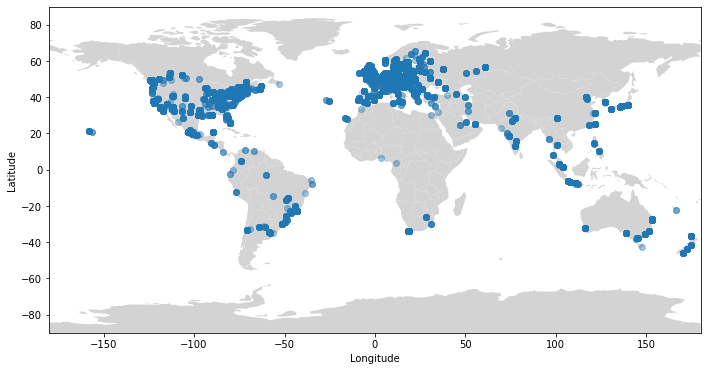

In [306]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

df = pd.read_csv('coordinates.csv')

#Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(12, 6))
worldmap.plot(color="lightgrey", ax=ax)

#Plot game dev locations
Longitudes = df['Longitudes']
Latitudes = df['Latitudes']
plt.scatter(x, y, alpha=0.4, vmin=0, cmap='autumn')

#Creating axis limits
plt.xlim([-180, 180])
plt.ylim([-90, 90])


plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [307]:
gameDevLocations

,company,city,state/province,country,alteredTextBool
1,0verflow,Tokyo,Tokyo,Japan,False
3,1 Simple Game,Zapopan,Jalisco,Mexico,False
5,100 Stones Interactive,Brisbane,Queensland,Australia,False
7,1047 Games,Zephyr Cove,Nevada,United States,False
9,10tons,Tampere,Tavastia,Finland,False
...,...,...,...,...,...
8153,Zwift,Long Beach,California,United States,False
8155,Zwift,Rio de Janeiro,Rio de Janeiro,Brazil,False
8157,Zynga Eugene,Eugene,Oregon,United States,False
8159,Zynga New York,New York City,New York,United States,False


In [25]:
#Find number of games with each tag in every year since oldest game on Steam

from os.path import exists

startDate = min(rawGames['releaseDate']).year
endDate = dt.now().year

#All unique tag names
uniqueTagNames = pd.Series([j for i in range(len(rawGames.tagsList)) for j in rawGames.tagsList[i]]).unique()

startTime = time.time()

if exists('SteamGamesTimeSeries.csv'):
    gamesTimeSeries = pd.read_csv('SteamGamesTimeSeries.csv')
    print('SteamGamesTimeSeries already exists.')

else:
    timeSeriesCSV = open('SteamGamesTimeSeries.csv','w+')
    writer = csv.writer(timeSeriesCSV)
    writer.writerow(tuple(['tagName']+[i for i in range(startDate,endDate+1)]))
    
    for tag in uniqueTagNames:
        dates = range(startDate,endDate+1)

        gamesCount=[]
        for date in dates:
            #How many games with this tag were released before "date"?
            
            tagGames = rawGames[tagBool(rawGames,[tag])]

            gamesCount.append(len(tagGames[[tagGames['releaseDate'][i].year < date for i in tagGames.index]].index))
            
        writer.writerow(tuple([tag] + gamesCount))
        
    timeSeriesCSV.close()
    
print(time.time() - startTime)
            
        

    

SteamGamesTimeSeries already exists.
0.012794971466064453


In [26]:
allGamesCount = gameGrowth(rawGames,min(ncrpgs_df['releaseDate']).year)

In [27]:
ncrpgCount = gameGrowth(ncrpgs_df,min(ncrpgs_df['releaseDate']).year)

In [28]:
crpgCount = gameGrowth(crpgs_df,min(ncrpgs_df['releaseDate']).year)

In [29]:
#How much porn is there on Steam?
startTime = time.time()
pornBool = tagBool(rawGames,['Nudity','Hentai','Mature'])
pornGames = rawGames[pornBool]


pornGamesCount = gameGrowth(pornGames,1985)

print(time.time() - startTime)

5.036567449569702


In [30]:
pornGames.head()

,appId,name,developerName,releaseDate,price,numReviews,positiveReviewPercentage,appGenre,tagsList,appType,dlcBool,appDesc,alteredTextBool
7,1688310,Perfect Affection Plan: Cassiopeia,Genesis Arthangel,2021-07-20,14.99,2.0,NaN,['Simulation'],"[Sexual Content, Simulation, Clicker, 2D, Anim...",All Games,False,"Kaede Uzuki, Everyone loves her, but finds lon...",False
57,1688000,My Cute Pagangirl - FREE Girls pack,CUTE ANIME GIRLS,2021-07-22,0.00,5.0,NaN,"['Adventure', 'Casual', 'Indie']","[Adventure, Indie, Casual, Nudity, Sexual Cont...",All Games,True,DLC ! GIRLS MODE .,True
124,1687780,THE ADVENTURES OF LWANDA MAGERE,Bethuel K. Okelo,2021-09-10,4.99,2.0,NaN,"['Action', 'Adventure', 'Indie']","[Adventure, Action, Singleplayer, Action-Adven...",All Games,False,This is an action-adventure game based on the ...,False
159,1687170,Buoy,Dmitry Klimov,NaT,NaN,NaN,NaN,"['Adventure', 'Indie', 'RPG', 'Simulation', 'E...","[Adventure, Survival, Crafting, Building, Mult...",All Games,False,After the cataclysm that occurred on planet Ea...,False
169,1687400,Pixie Farm VR / VR,kan.kikuchi,NaT,NaN,NaN,NaN,['Simulation'],"[Simulation, VR, Anime, Cute, Hentai, Roguelit...",All Games,False,Pixie Farm VR is a pixie raising simulation VR...,False


In [31]:
rawGames[rawGames.name == "Baldur's Gate II: Enhanced Edition"].tagsList.tolist()

[['RPG',
  'Dungeons & Dragons',
  'Fantasy',
  'Story Rich',
  'Tabletop',
  'CRPG',
  'Party-Based RPG',
  'Open World',
  'Adventure',
  'Real-Time with Pause',
  'Character Customization',
  'Multiplayer',
  'Choices Matter',
  'Magic',
  'Online Co-Op',
  'Atmospheric',
  'Action-Adventure',
  'Singleplayer',
  'Isometric',
  'Old School']]

In [32]:
tagTS = pd.read_csv('SteamGamesTimeSeries.csv',index_col=0)

In [33]:
tagTS.head()

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
tagName,,,,,,,,,,,,,,,,,,,,,
Casual,0,0,0,0,0,0,0,0,0,0,...,1136,1501,2360,3791,6403,10180,15357,20301,26642,36105
Action,0,1,1,1,1,1,1,1,1,1,...,2356,3014,4116,6030,9101,13361,18650,24300,30835,40036
3D Fighter,0,0,0,0,0,0,0,0,0,0,...,6,7,11,13,21,34,45,67,182,439
Shooter,0,0,0,0,0,0,0,0,0,0,...,710,803,1002,1246,1577,2038,2568,3129,4339,6129
Runner,0,0,0,0,0,0,0,0,0,0,...,6,11,21,39,75,119,180,240,423,832


In [34]:
#Function to plot number of games with certain tags over time
def tagNumberPlot(tagNameList):
    plt.figure()

    #Define time range: oldest game on steam to current year
    startDate = min(rawGames['releaseDate']).year
    endDate = dt.now().year
    
    dates = range(startDate,endDate+1)
    
    #Plot all tag time series
    for tag in tagNameList:
        plt.plot(dates, tagTS.loc[tag].values, label=tag)
    
    plt.xlabel('Year')
    plt.ylabel('Number games')

    plt.grid()
    plt.legend()
    return

In [35]:
totalGamesCount = gameGrowth(rawGames,min(rawGames['releaseDate']).year)

In [36]:
#Function to plot proportion of games with certain tags over time
def tagProportionPlot(tagNameList):
    plt.figure()

    #Define time range: oldest game on steam to current year
    startDate = min(rawGames['releaseDate']).year
    endDate = dt.now().year
    
    dates = range(startDate,endDate+1)
    
    #Plot all tag time series
    for tag in tagNameList:
        plt.plot(dates, [tagTS.loc[tag].values[i]/totalGamesCount[i] for i in range(len(dates))], label=tag)
    
    plt.xlabel('Year')
    plt.ylabel('Proportion of games')

    plt.grid()
    plt.legend()
    return

C:\Users\phyis\AppData\Local\Temp/ipykernel_29808/3832377546.py:13: RuntimeWarning: invalid value encountered in longlong_scalars
  plt.plot(dates, [tagTS.loc[tag].values[i]/totalGamesCount[i] for i in range(len(dates))], label=tag)


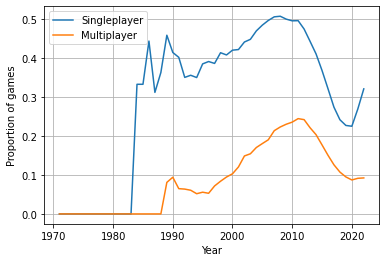

In [49]:
tagProportionPlot(['Singleplayer','Multiplayer'])

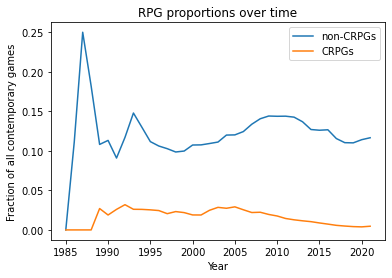

In [38]:
#Plot change in proportion of RPGs over time
plt.figure()

dates = range(min(ncrpgs_df['releaseDate']).year,dt.now().year)

plt.plot([dates[i] for i in range(len(dates)) if allGamesCount[i]>0], [ncrpgCount[i]/allGamesCount[i] for i in range(len(dates)) if allGamesCount[i]>0],label='non-CRPGs')
plt.plot([dates[i] for i in range(len(dates)) if allGamesCount[i]>0], [crpgCount[i]/allGamesCount[i] for i in range(len(dates)) if allGamesCount[i]>0],label='CRPGs')
# plt.plot(dates, crpgCount)

plt.title('RPG proportions over time')
plt.xlabel('Year')
plt.ylabel('Fraction of all contemporary games')

plt.legend()

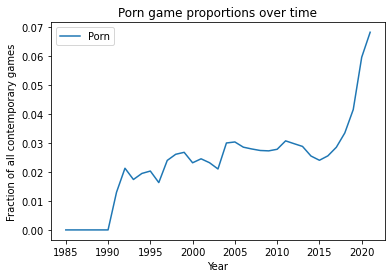

In [39]:
#Plot change in proportion of RPGs over time
plt.figure()

dates = range(1985,dt.now().year)

plt.plot([dates[i] for i in range(len(dates)) if allGamesCount[i]>0], [pornGamesCount[i]/allGamesCount[i] for i in range(len(dates)) if allGamesCount[i]>0],label='Porn')


plt.title('Porn game proportions over time')
plt.xlabel('Year')
plt.ylabel('Fraction of all contemporary games')

plt.legend()

## Review Data and Game Recommender

In [283]:
reviews = pd.read_json('SteamReviewsData.json')

In [920]:
#Create a dataframe containing all review info, with columns for
#author IDs, app IDs, and ratings (Boolean variable, 1 = positive rating, 0 = negative rating)
authorIDs = [];
gameIDs = [];
ratings = [];

for index, game in reviews.iterrows():
    for recommendation in game['reviews']:
        authorIDs.append(recommendation['author']['steamid'])
        gameIDs.append(game['appId'])
        
        gameRating = recommendation['voted_up']
        numReviews = len(game['reviews'])
        #Append gameRating = 1 if voted_up == True, and = -1 if voted_up == False
        ratings.append(gameRating + (1 - gameRating)*-1)
        
        #Also weight this value by number of reviews this game received
        #ratings.append((gameRating + (1 - gameRating)*-1)/numReviews)
        
        
        
reviewsDict = {'authorID': authorIDs, 'appID': gameIDs, 'rating': ratings};

reviewsData = pd.DataFrame(data=reviewsDict).sort_values(by=['authorID']).drop_duplicates(['authorID','appID'])

In [776]:
#Create empty list for collecting the counts of reviews for each author
authorReviewsCount = {}

#Create dictionary of review counts for each author, initialized to zero
for uniqueAuthor in reviewsData['authorID'].unique():
    
    #Append to dictionary
    authorReviewsCount[uniqueAuthor] = 0
    
#Iterate through review data
for review in reviewsData.iterrows():
    
    #Add to review count
    authorReviewsCount[review[1]['authorID']] = authorReviewsCount[review[1]['authorID']] + 1

In [815]:
len(reviewsData['authorID'].unique())

247703

Text(0.5, 0, 'Number of reviews')

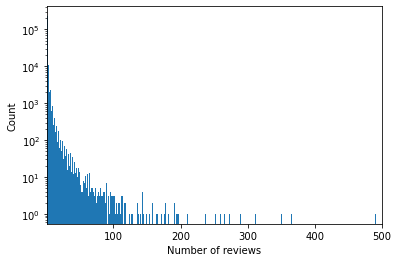

In [821]:
#Make a histogram of review numbers
plt.hist(authorReviewsCount.values(), bins = 500)

plt.xlim(1,500)
plt.yscale('log')
plt.ylabel('Count')
plt.xlabel('Number of reviews')

There are >100,000 reviewers (accounting for about about 40% of all reviews) who have left only 1 review, and about half of users left fewer than 2 reviews. We can try training on this data and try another model only including reviewers with 2 or more reviews.

In [1050]:
#Restrict dataset to reviewers with more than 10 reviews

reviewNumberCutoff = 1

reviewsDataCutoff = {}

for review in reviewsData.iterrows():
    
    if authorReviewsCount[review[1]['authorID']] >= reviewNumberCutoff:
        reviewsDataCutoff[review[0]] = True
        
    else:
        reviewsDataCutoff[review[0]] = False

#Create Boolean indexing array
reviewsCutoffBool = pd.Series(reviewsDataCutoff)

#Remove reviewers with review counts below the cutoff
reviewsDataCutoff = reviewsData[reviewsCutoffBool]

reviewsDataCutoff.reset_index()

,index,authorID,appID,rating
0,106503,76561197960265841,1825540,1
1,299147,76561197960265942,310110,-1
2,258749,76561197960268079,446110,1
3,30044,76561197960268765,1542040,1
4,71200,76561197960268765,1081870,1
...,...,...,...,...
392698,107385,76561199367992022,1868050,1
392699,360963,76561199368056737,356570,1
392700,104381,76561199368683393,1806610,1
392701,387657,76561199368686333,960990,-1


In [1051]:
from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype

authorUnique = CategoricalDtype(sorted(reviewsDataCutoff.authorID.unique()), ordered=True)
appUnique = CategoricalDtype(sorted(reviewsDataCutoff.appID.unique()), ordered=True)

reviewRow = reviewsDataCutoff.authorID.astype(authorUnique).cat.codes
reviewCol = reviewsDataCutoff.appID.astype(appUnique).cat.codes

# reviewCol = reviewsDataCutoff.authorID.astype(authorUnique).cat.codes
# reviewRow = reviewsDataCutoff.appID.astype(appUnique).cat.codes

reviewSparseMatrix = csr_matrix((reviewsDataCutoff['rating'], (reviewRow, reviewCol)), \
                                shape=(authorUnique.categories.size, appUnique.categories.size))

# reviewSparseMatrix = csr_matrix((reviewsDataCutoff['rating'], (reviewRow, reviewCol)), \
#                                 shape=(appUnique.categories.size, authorUnique.categories.size))


In [996]:
reviewSparseMatrix.shape

(2726, 30764)

In [864]:
userDict = {};
counter = 0

for authorID in authorUnique.categories:
    userDict[authorID] = counter
    counter += 1

In [848]:
itemDict ={}

reviewGameNames = [rawGames[rawGames['appId'] == appID]['name'].to_string(index=False) \
                  for appID in reviewsData['appID'].to_list()]

itemDictDF = pd.DataFrame({'appID': reviewsData['appID'].to_list(), 'appName': reviewGameNames}).sort_values('appID').reset_index()

for i in range(itemDictDF.shape[0]):
    itemDict[(itemDictDF.loc[i,'appID'])] = itemDictDF.loc[i,'appName']


In [1052]:
#Split data into training and test sets
from lightfm.cross_validation import random_train_test_split

reviewSparseMatrix_train, reviewSparseMatrix_test = random_train_test_split(reviewSparseMatrix, random_state=42)

In [1053]:
from lightfm import LightFM

model = LightFM(loss='logistic',
                random_state=42,
                learning_rate=0.5,
                learning_schedule='adadelta',
                rho=0.99,
                epsilon=1e-1)
model = model.fit(reviewSparseMatrix_train,
                  epochs=100,
                  num_threads=16, verbose=False)

KeyboardInterrupt: 

In [1042]:
#Get top five recommendations for userX

user = 0
numUsers = 10

while user < numUsers:
    userX = userDict[np.random.choice(authorUnique.categories)]
    print(userX)   
    n_items, n_users = reviewSparseMatrix_test.shape

    scores = np.array(model.predict(userX,np.arange(n_items), item_features=reviewSparseMatrix_test))

    top5GamesBool = pd.Series(scores).nlargest(n=5).index

    print(pd.Series(appUnique.categories)[top5GamesBool].values)

    top5List = []
    for top5Game in pd.Series(appUnique.categories)[top5GamesBool].values:
        top5List.append(rawGames[rawGames['appId'] == top5Game]['name'].values[0])

    print(top5List)
    
    user += 1

    # rawGames['appId'] == appUnique.categories[top5GameIndex])

    # top5GameName = rawGames[gameBool]['name'].to_string(index=False)

2503
[222543 204220     50 234570 203140]
['Train Simulator: Norfolk Southern Heritage SD70ACes Loco Add-On', 'Snapshot', 'Half-Life: Opposing Force', 'QUBE: Against the Qlock', 'Hitman: Absolution\x99']
254
[105420 200185  65256  16040 208349]
['Ms. Splosion Man', 'Worms Revolution: Medieval Tales DLC', 'Train Simulator: BR Class 423 \x914VEP\x92 EMU Add-On', 'Luxor: Quest for the Afterlife ', "Train Simulator: SP&S E-1 Class 'Northern' Loco Add-On"]
2214
[222543 251530 234570 200185 238303]
['Train Simulator: Norfolk Southern Heritage SD70ACes Loco Add-On', 'Anomaly Korea', 'QUBE: Against the Qlock', 'Worms Revolution: Medieval Tales DLC', 'Saints Row IV - The Rectifier']
1020
[251530  38150 232990 208283  15800]
['Anomaly Korea', 'Farm Frenzy 3', 'Waves Soundtrack', 'Train Simulator: DB ICE 3 EMU Add-On', 'Planet Busters']
2340
[ 31190 222543 204220 200185 211209]
['Tales of Monkey Island Complete Pack: Chapter 3 - Lair of the Leviathan', 'Train Simulator: Norfolk Southern Heritage 

In [1045]:
#Evaluate model performance
from lightfm.evaluation import auc_score

performanceScore = auc_score(model, reviewSparseMatrix_test, train_interactions=reviewSparseMatrix_train)

In [1046]:
np.average(performanceScore)

0.51500666

In [1054]:
import itertools

import numpy as np

from lightfm import LightFM
from lightfm.evaluation import auc_score


def sample_hyperparameters():
    """
    Yield possible hyperparameter choices.
    """

    while True:
        yield {
            "no_components": np.random.randint(40, 84),
            "learning_schedule": np.random.choice(["adagrad", "adadelta"]),
            "loss": np.random.choice(["bpr", "warp", "warp-kos"]),
            "learning_rate": np.random.exponential(0.05),
            "item_alpha": np.random.exponential(1e-8),
            "user_alpha": np.random.exponential(1e-8),
            "max_sampled": np.random.randint(5, 15),
            "num_epochs": np.random.randint(5, 50),
        }


def random_search(train, test, num_samples=10, num_threads=1):
    """
    Sample random hyperparameters, fit a LightFM model, and evaluate it
    on the test set.

    Parameters
    ----------

    train: np.float32 coo_matrix of shape [n_users, n_items]
        Training data.
    test: np.float32 coo_matrix of shape [n_users, n_items]
        Test data.
    num_samples: int, optional
        Number of hyperparameter choices to evaluate.


    Returns
    -------

    generator of (auc_score, hyperparameter dict, fitted model)

    """

    for hyperparams in itertools.islice(sample_hyperparameters(), num_samples):
        num_epochs = hyperparams.pop("num_epochs")

        model = LightFM(**hyperparams)
        model.fit(train, epochs=num_epochs, num_threads=num_threads)

        score = auc_score(model, test, train_interactions=train, num_threads=num_threads).mean()

        hyperparams["num_epochs"] = num_epochs

        yield (score, hyperparams, model)


if __name__ == "__main__":
    train = reviewSparseMatrix_train
    test = reviewSparseMatrix_test

    (score, hyperparams, model) = max(random_search(train, test, num_threads=2), key=lambda x: x[0])

    print("Best score {} at {}".format(score, hyperparams))

Best score 0.7345967292785645 at {'no_components': 44, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.009298331793000566, 'item_alpha': 8.897488524832826e-09, 'user_alpha': 1.6628688874535134e-09, 'max_sampled': 13, 'num_epochs': 26}


In [1055]:
#Optimization results:
#
#Performances on dataset with cutoff at 10 reviews:
#
#(Number of models = 10) Best score 0.651569664478302 at {'no_components': 52, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.1527113318869582, 'item_alpha': 1.0645979288543401e-08, 'user_alpha': 1.111435154654254e-08, 'max_sampled': 14, 'num_epochs': 20}
#
#(Number of models = 100) Best score 0.6798270344734192 at {'no_components': 55, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.14499587224888172, 'item_alpha': 2.449496687288527e-08, 'user_alpha': 3.5844794576049884e-08, 'max_sampled': 6, 'num_epochs': 37}
#
#Performances on dataset with no cutoff:
#
#(Number of models = 10) Best score 0.7345967292785645 at {'no_components': 44, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.009298331793000566, 'item_alpha': 8.897488524832826e-09, 'user_alpha': 1.6628688874535134e-09, 'max_sampled': 13, 'num_epochs': 26}
#

In [990]:
author_ID = list(userDict.keys())[list(userDict.values()).index(1224)]

print(author_ID)

reviewsData[reviewsData['authorID'] == author_ID]


76561198044983093


,authorID,appID,rating
262411,76561198044983093,436490,1
342155,76561198044983093,328230,1
316186,76561198044983093,420840,1
181939,76561198044983093,514350,-1
233938,76561198044983093,111010,1
209688,76561198044983093,547040,-1
262615,76561198044983093,435490,1
183187,76561198044983093,512240,1
174573,76561198044983093,535010,1
233919,76561198044983093,111000,-1


In [991]:
app_ID = reviewsData[reviewsData['authorID'] == author_ID]['appID']

for game in app_ID.values:
    print(rawGames[rawGames['appId'] == game].name.values)

['Firebird - La Peri']
['A Bird Story - Original Soundtrack']
['BLARP!']
['Fancy Slingshot VR']
['The Clockwork Man: The Hidden World']
['Above - VR']
['Pierhead Arcade']
['Duckpocalypse']
['Pen Island VR']
['The Clockwork Man']
['Holopoint']
['MURI']
['[ R.U.M.A ]']
['Jane Angel: Templar Mystery']
['Crystals of Time']
['BellyBots']
['Zombie Training Simulator']
['Cyberpong']
['Where Angels Cry']
['Amazing Adventures Around the World']
["Robin's Quest"]
['Storm VR']
['Battle Dome']
['Omega Agent']
['Titans of Space PLUS']


In [661]:
app_ID.values[0]

984660